In [18]:
import pandas as pd
## Utils and Library for notebook
from notebook_utils.OpenKbcMSToolkit import ExtractionToolkit as exttoolkit

# Root data path
DATA_PATH = '../data/'

#Data loading
df = pd.read_csv("resultFiles/featureExtractionV5_by_Jun/CD4.Ranksum.RFECV.act.csv", engine='c', index_col=0)
meta_data = pd.read_csv(DATA_PATH+'annotation_metadata/EPIC_HCvB_metadata_baseline_updated-share.csv')


In [19]:
## Utils and Library for notebook
from notebook_utils.OpenKbcMSToolkit import ExtractionToolkit as exttoolkit
import itertools
def _LoadDiseaseDuration(df, meta_data, returntype='long'):
    """
    df : Expression or activation score matrix
    meta_data : meta data which contains duration and sample ID
    output: long DD samples and short DD samples by list, or healthy samples and short DD samples by list
    """
    # checking multiple element for returntype
    if returntype.count(',')>1: raise ValueError('No more than 2 elements for returntype')

    if returntype.find(',')==-1: # if returnType is single(long and healthy)
        # Sample by disease category
        sample_list, sample_category = exttoolkit.get_sample_name_by_category(dataframe=meta_data, sampleColumn='HCVB_ID', dataColname='DiseaseCourse')
        
        # Sort by disease category and exclude uknown samples
        patient_samples = [] # patient samples
        healthy_samples = [] # healthy samples
        for samples, category in zip(sample_list, sample_category):
            if category=='Healthy':
                healthy_samples = samples
            else:
                if category!='Unknown':# Excluding unknown samples
                    patient_samples.append(samples)

        patient_samples = list(itertools.chain(*patient_samples)) # flatten
        patient_samples = list(set(patient_samples).intersection(df.columns.tolist())) # intersected with act score matrix
        healthy_samples = list(set(healthy_samples).intersection(df.columns.tolist())) # intersected with act score matrix
        patient_meta = meta_data.loc[meta_data['HCVB_ID'].isin(patient_samples)] # Make patient metadata

        longDD_samples, shortDD_samples = exttoolkit.get_sample_name_by_contValues(patient_meta, 'HCVB_ID', 'DiseaseDuration', 25)
        longDD_samples = list(set(longDD_samples.values.tolist()).intersection(df.columns.tolist())) # intersected with act score matrix
        shortDD_samples = list(set(shortDD_samples.values.tolist()).intersection(df.columns.tolist())) # intersected with act score matrix

    else: # if returnType is multiple(List)
        # Sample by disease category
        sample_list, sample_category = exttoolkit.get_sample_name_by_category(dataframe=meta_data, sampleColumn='HCVB_ID', dataColname='DiseaseCourse')
        category1 = returntype.split(',')[0]
        category2 = returntype.split(',')[1]
        
        # Sort by disease category and exclude uknown samples
        patient_samples = [] # patient samples
        healthy_samples = [] # healthy samples
        for samples, category in zip(sample_list, sample_category):
            if category==category1:
                category1_samples = list(set(samples).intersection(df.columns.tolist())) # intersected with act score matrix
            elif category==category2:
                category2_samples = list(set(samples).intersection(df.columns.tolist())) # intersected with act score matrix

    # return result
    if returntype=='long':
        return longDD_samples, shortDD_samples
    elif returntype=='healthy':
        return healthy_samples, shortDD_samples
    else:
        return category1_samples, category2_samples


In [20]:
df_cd4 = df.copy()
rr_samples, cis_samples = _LoadDiseaseDuration(df_cd4, meta_data, 'RR,CIS')
df_cd4 = df_cd4[rr_samples+cis_samples]
df_cd4 = df_cd4.subtract(df_cd4.median(axis=1), axis=0)

/opt/miniconda3/envs/r-py-test/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


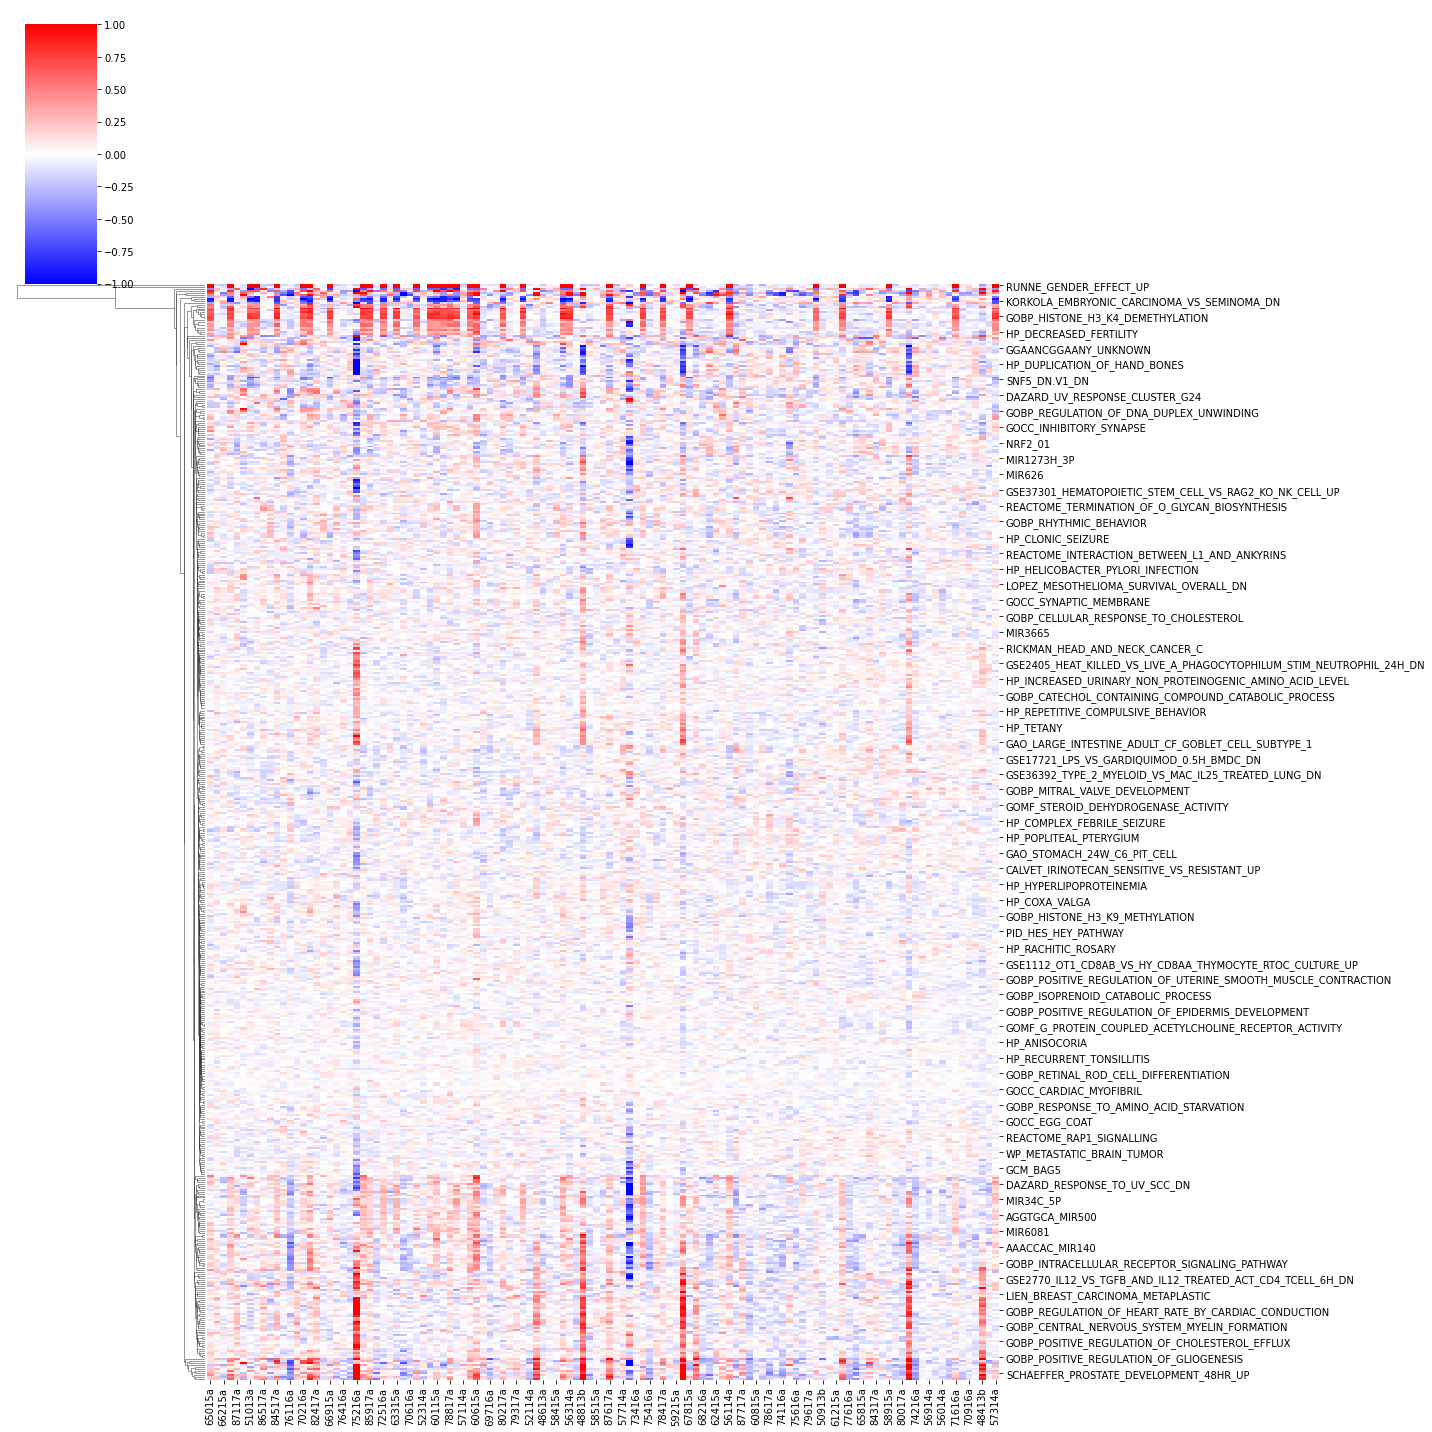

In [21]:
import seaborn as sns
sns.clustermap(df_cd4, col_cluster=False, figsize=(20,20), cmap='bwr', vmin=-1, vmax=1)


In [22]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = df_cd4.T.values
pca.fit(X)
x_updated = pca.transform(X)
x_updated.shape


(119, 2)

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

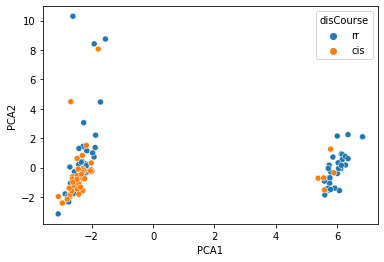

In [24]:
pca_df = pd.DataFrame(data=x_updated, index=df_cd4.T.index, columns=['PCA1', 'PCA2'])
pca_df['disCourse'] = np.where(pca_df.index.isin(rr_samples),'rr', 'cis' )
sns.scatterplot(x='PCA1', y='PCA2', hue='disCourse', data=pca_df)

